In [189]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [190]:
from tqdm import tqdm

In [296]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder

In [263]:
data=pd.read_csv("../data/train_data.csv")
#wtd 로 바꾸기


In [264]:
# x,y 추가.
turblocation=pd.read_csv("../data/turb_location.csv")

data=pd.merge(data,turblocation,how='inner',on='TurbID')




In [265]:
test=pd.read_csv("../data/sample_submission.csv")

In [266]:
data=data.fillna(method="ffill").fillna(method="bfill")

In [267]:
data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,x,y
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,3349.8515,5939.23193
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,3349.8515,5939.23193
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,3349.8515,5939.23193
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,3349.8515,5939.23193
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,3349.8515,5939.23193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,11.3385,6713.46517
3859196,134,200,23:20,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,11.3385,6713.46517
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,11.3385,6713.46517
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,11.3385,6713.46517


In [268]:
# 추가 수치형 피쳐
# 터빈별 mean, std, var, max, min
for i in tqdm(range(1, 135)):
    data.loc[data['TurbID']==i, 'Turbin_Wspd_mean'] = data[data['TurbID']==i]['Wspd'].mean()
    data.loc[data['TurbID']==i, 'Turbin_Wspd_var'] = data[data['TurbID']==i]['Wspd'].var()
    data.loc[data['TurbID']==i, 'Turbin_Wspd_max'] = data[data['TurbID']==i]['Wspd'].max()
    data.loc[data['TurbID']==i, 'Turbin_Wspd_min'] = data[data['TurbID']==i]['Wspd'].min()
    
# Day 별 풍속 mean, std, var, max, min
for i in tqdm(range(1, 201)): # 1~ 200일
    data.loc[data['Day']==i, 'Day_Wspd_mean'] = data[data['Day']==i]['Wspd'].mean()
    data.loc[data['Day']==i, 'Day_Wspd_var'] = data[data['Day']==i]['Wspd'].var()
    data.loc[data['Day']==i, 'Day_Wspd_max'] = data[data['Day']==i]['Wspd'].max()
    data.loc[data['Day']==i, 'Day_Wspd_min'] = data[data['Day']==i]['Wspd'].min()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.20it/s]


In [269]:
# 날짜 만들기
from datetime import datetime
from datetime import timedelta
dt = datetime(2020, 12, 31,23,50)
Days= []
for i in range(28800): 
    dt = dt + timedelta(minutes=10)
    dd=dt.strftime("%Y-%m-%d %H:%M")
    Days.append(dd)
    
data['Day']=Days*134


In [270]:
tms_list = list(pd.unique(data["Tmstamp"]))
#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )
#train_data["Tmstamp"] = train_data["Tmstamp"]//6
hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]
data["Tmstamp"] = data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


In [271]:
data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,...,x,y,Turbin_Wspd_mean,Turbin_Wspd_var,Turbin_Wspd_max,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min
0,1,2021-01-01 00:00,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,...,3349.8515,5939.23193,5.604128,13.183754,23.20,0.0,7.310792,8.225820,15.97,0.0
1,1,2021-01-01 00:10,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,...,3349.8515,5939.23193,5.604128,13.183754,23.20,0.0,7.310792,8.225820,15.97,0.0
2,1,2021-01-01 00:20,0,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,...,3349.8515,5939.23193,5.604128,13.183754,23.20,0.0,7.310792,8.225820,15.97,0.0
3,1,2021-01-01 00:30,0,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,...,3349.8515,5939.23193,5.604128,13.183754,23.20,0.0,7.310792,8.225820,15.97,0.0
4,1,2021-01-01 00:40,0,6.25,0.89,30.49,41.38,20.91,1.00,1.00,...,3349.8515,5939.23193,5.604128,13.183754,23.20,0.0,7.310792,8.225820,15.97,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,2021-07-19 23:10,23,4.86,4.68,9.04,10.40,174.39,0.01,0.01,...,11.3385,6713.46517,5.184461,11.114256,19.81,0.0,3.087817,3.870614,9.57,0.0
3859196,134,2021-07-19 23:20,23,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,...,11.3385,6713.46517,5.184461,11.114256,19.81,0.0,3.087817,3.870614,9.57,0.0
3859197,134,2021-07-19 23:30,23,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,...,11.3385,6713.46517,5.184461,11.114256,19.81,0.0,3.087817,3.870614,9.57,0.0
3859198,134,2021-07-19 23:40,23,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,...,11.3385,6713.46517,5.184461,11.114256,19.81,0.0,3.087817,3.870614,9.57,0.0


In [272]:
data['Day']=pd.to_datetime(data['Day'])

In [273]:
data['Day']

0         2021-01-01 00:00:00
1         2021-01-01 00:10:00
2         2021-01-01 00:20:00
3         2021-01-01 00:30:00
4         2021-01-01 00:40:00
                  ...        
3859195   2021-07-19 23:10:00
3859196   2021-07-19 23:20:00
3859197   2021-07-19 23:30:00
3859198   2021-07-19 23:40:00
3859199   2021-07-19 23:50:00
Name: Day, Length: 3859200, dtype: datetime64[ns]

In [274]:
# add time index
data['time_idx'] = ( ( (data["Day"].dt.dayofyear-1)*24*60 + data["Day"].dt.hour*60 + data["Day"].dt.minute ) /10 ).astype(int)

#data["time_idx"] = data["Day"].dt.year * 12 + data["Day"].dt.month + data["Day"].dt.hour
#data["time_idx"] -= data["time_idx"].min()

In [275]:
np.unique(data["time_idx"])

array([    0,     1,     2, ..., 28797, 28798, 28799])

In [276]:
prediction_steps=288

In [277]:
data['Day']

0         2021-01-01 00:00:00
1         2021-01-01 00:10:00
2         2021-01-01 00:20:00
3         2021-01-01 00:30:00
4         2021-01-01 00:40:00
                  ...        
3859195   2021-07-19 23:10:00
3859196   2021-07-19 23:20:00
3859197   2021-07-19 23:30:00
3859198   2021-07-19 23:40:00
3859199   2021-07-19 23:50:00
Name: Day, Length: 3859200, dtype: datetime64[ns]

In [278]:
data.Day.dt.isocalendar().week

0          53
1          53
2          53
3          53
4          53
           ..
3859195    29
3859196    29
3859197    29
3859198    29
3859199    29
Name: week, Length: 3859200, dtype: UInt32

In [279]:
# add additional features
data["month"] = data.Day.dt.month.astype(str).astype("category")  # categories have be strings
data["hour"] = data.Day.dt.hour.astype(str).astype("category")
data["Tmstamp"] = data["Tmstamp"].astype(str).astype("category")
data['Week'] = data.Day.dt.weekofyear.astype(str).astype("category")
data['TurbID'] = data['TurbID'].astype(str).astype("category")

# x,y 관련 추가 데이터
data["distance"] = np.sqrt(data["x"]**2+data["y"]**2)




C:\Users\USER\AppData\Local\Temp/ipykernel_1884/3707043896.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['Week'] = data.Day.dt.weekofyear.astype(str).astype("category")


In [280]:

data.sample(10, random_state=521)

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,...,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min,time_idx,month,hour,Week,distance
2073455,72,2021-07-18 23:50:00,23,6.92,1.45,8.61,17.64,155.91,11.40,11.40,...,0.0,11.559790,23.689580,22.30,0.00,28655,7,23,28,7421.170194
418980,15,2021-04-20 14:00:00,14,2.22,8.98,37.91,39.20,211.95,88.56,88.52,...,0.0,2.509609,2.497738,11.89,0.00,15780,4,14,16,3537.459169
1636279,57,2021-06-13 01:10:00,1,2.83,-0.46,10.94,26.75,195.16,0.01,0.01,...,0.0,3.318361,5.304038,10.19,0.00,23479,6,1,23,12385.533349
289539,11,2021-01-11 16:30:00,16,9.14,0.18,26.00,28.10,352.72,5.10,5.10,...,0.0,9.981453,4.710700,16.53,0.00,1539,1,16,2,12089.442604
1692630,59,2021-06-04 09:00:00,9,2.00,-1.18,14.99,23.62,171.69,22.83,22.83,...,0.0,2.883878,2.726115,11.55,0.00,22230,6,9,22,5333.004503
2740933,96,2021-02-04 06:10:00,6,2.27,27.14,27.15,29.97,149.91,89.35,89.34,...,0.0,3.193249,3.070962,12.09,0.00,4933,2,6,5,9357.748821
1310796,46,2021-04-13 18:00:00,18,1.16,39.74,28.61,35.99,-86.87,90.39,90.37,...,0.0,2.551160,2.857270,11.23,0.00,14796,4,18,15,6438.947103
3276571,114,2021-06-03 23:10:00,23,1.28,-28.96,17.39,19.78,428.26,90.38,90.38,...,0.0,3.377351,3.841639,11.17,0.28,22171,6,23,22,7662.352335
1069094,38,2021-01-25 06:20:00,6,6.16,2.76,394.04,21.58,336.42,0.02,0.02,...,0.0,4.322061,2.059803,11.00,0.00,3494,1,6,4,4411.464934
1577541,55,2021-06-05 03:30:00,3,5.46,-0.47,10.85,18.96,317.85,0.04,0.04,...,0.0,8.411959,5.339100,15.12,0.00,22341,6,3,22,11497.868138


In [281]:
data.describe()

,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,...,Turbin_Wspd_mean,Turbin_Wspd_var,Turbin_Wspd_max,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min,time_idx,distance
count,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,...,3.859200e+06,3.859200e+06,3.859200e+06,3859200.0,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06
mean,5.227723e+00,2.155489e-01,4.576769e+01,3.120062e+01,1.841911e+02,2.585133e+01,2.582708e+01,2.581092e+01,-1.529130e+01,3.575309e+02,...,5.227723e+00,1.177698e+01,2.276604e+01,0.0,5.227723e+00,5.764090e+00,1.323890e+01,1.045500e-01,1.439950e+04,7.018941e+03
std,3.444270e+00,2.988544e+01,8.456315e+01,1.842011e+01,1.678035e+02,3.818367e+01,3.817262e+01,3.816318e+01,7.087493e+01,4.242845e+02,...,2.939705e-01,1.149129e+00,1.282210e+00,0.0,2.469657e+00,4.424169e+00,4.000233e+00,6.078535e-01,8.313845e+03,2.849324e+03
min,0.000000e+00,-3.030460e+03,-2.730300e+02,-2.731700e+02,-8.848600e+02,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,0.000000e+00,...,4.567170e+00,9.527519e+00,1.939000e+01,0.0,9.924559e-01,4.639451e-01,4.660000e+00,0.000000e+00,0.000000e+00,1.939488e+03
25%,2.430000e+00,-3.840000e+00,2.068000e+01,2.610000e+01,5.037000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-4.177000e+01,0.000000e+00,...,5.048584e+00,1.102622e+01,2.191000e+01,0.0,3.370338e+00,2.867782e+00,1.071000e+01,0.000000e+00,7.199750e+03,4.726323e+03
50%,4.580000e+00,-2.600000e-01,2.829000e+01,3.281000e+01,1.911500e+02,5.700000e-01,5.700000e-01,5.600000e-01,-3.100000e-01,1.917200e+02,...,5.198545e+00,1.155610e+01,2.276500e+01,0.0,4.681810e+00,4.501280e+00,1.247500e+01,0.000000e+00,1.439950e+04,6.766135e+03
75%,7.260000e+00,3.300000e+00,3.398000e+01,3.820000e+01,3.218500e+02,7.812000e+01,7.772000e+01,7.751000e+01,-2.300000e-01,5.600100e+02,...,5.393310e+00,1.241716e+01,2.374000e+01,0.0,6.339045e+00,7.138484e+00,1.578250e+01,0.000000e+00,2.159925e+04,9.164606e+03
max,2.629000e+01,2.266950e+03,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.852000e+02,1.567020e+03,...,6.399195e+00,1.652660e+01,2.629000e+01,0.0,1.340057e+01,2.604460e+01,2.629000e+01,6.220000e+00,2.879900e+04,1.263130e+04


In [282]:
data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,...,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min,time_idx,month,hour,Week,distance
0,1,2021-01-01 00:00:00,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,0,1,0,53,6818.796154
1,1,2021-01-01 00:10:00,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,1,1,0,53,6818.796154
2,1,2021-01-01 00:20:00,0,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,2,1,0,53,6818.796154
3,1,2021-01-01 00:30:00,0,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,3,1,0,53,6818.796154
4,1,2021-01-01 00:40:00,0,6.25,0.89,30.49,41.38,20.91,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,4,1,0,53,6818.796154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,2021-07-19 23:10:00,23,4.86,4.68,9.04,10.40,174.39,0.01,0.01,...,0.0,3.087817,3.870614,9.57,0.0,28795,7,23,29,6713.474745
3859196,134,2021-07-19 23:20:00,23,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,...,0.0,3.087817,3.870614,9.57,0.0,28796,7,23,29,6713.474745
3859197,134,2021-07-19 23:30:00,23,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,...,0.0,3.087817,3.870614,9.57,0.0,28797,7,23,29,6713.474745
3859198,134,2021-07-19 23:40:00,23,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,...,0.0,3.087817,3.870614,9.57,0.0,28798,7,23,29,6713.474745


In [283]:
np.unique(data['TurbID']).shape

(134,)

In [284]:
data["time_idx"]

0              0
1              1
2              2
3              3
4              4
           ...  
3859195    28795
3859196    28796
3859197    28797
3859198    28798
3859199    28799
Name: time_idx, Length: 3859200, dtype: int32

In [285]:
max_prediction_length = 288
data["time_idx"].max() - max_prediction_length  #validation 시작 time

28511

In [286]:
data.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv', 'x', 'y', 'Turbin_Wspd_mean',
       'Turbin_Wspd_var', 'Turbin_Wspd_max', 'Turbin_Wspd_min',
       'Day_Wspd_mean', 'Day_Wspd_var', 'Day_Wspd_max', 'Day_Wspd_min',
       'time_idx', 'month', 'hour', 'Week', 'distance'],
      dtype='object')

# 데이터 로더

In [371]:
max_prediction_length = 288 # 288 time_idx를 예측한다. validation도 288개만 수행된다.
max_encoder_length = 144*5
training_cutoff = data["time_idx"].max() - max_prediction_length 

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx", #시간 인덱스
    target="Wspd", # 타겟 벨류
    group_ids=["TurbID",], # Turbid 기준
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    #시간이 지나도 안변하는 카테고리.
    static_categoricals=["TurbID",],
    #시간이 지나도 안변하는 수치형. 
    static_reals=["x","y","distance"],
    #시간이 지나면 변하고, 미래에 알 수 있는 것.
    #test set에도 똑같이 존재해야한다.
    time_varying_known_categoricals=["Tmstamp", "month","hour","Week"],
    #
    variable_groups={},  # group of categorical variables can be treated as one variable
    #시간이 지나도 알 수 있는것
    time_varying_known_reals=["time_idx",], 
    # 시간이 지나면 변하지만, 알 수 없는것. target 처럼
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Wspd",
        "Wdir",
        "Etmp",
        "Itmp",
        "Ndir",
        "Pab1",
        "Pab2",
        "Pab3",
        "Patv",
        #"Turbin_Wspd_mean",
        #"Turbin_Wspd_var",
        #"Turbin_Wspd_max",
        #"Turbin_Wspd_min",
        #"Day_Wspd_mean",
        #"Day_Wspd_var",
        #"Day_Wspd_max",
        #"Day_Wspd_min",
        
    ],
    categorical_encoders={"Week":NaNLabelEncoder(add_nan=True),},
    target_normalizer = GroupNormalizer(
        groups=["TurbID",], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    #
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True
                                            # week때문에 추가. 없는 week에 대해서는 알아서 처리 못해주는걸로 보인다.
                                           )
#predict = true로 검증셋 제작.

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_forecasting\data\encoders.py:311: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [372]:
validation

TimeSeriesDataSet[length=134](
	time_idx='time_idx',
	target='Wspd',
	group_ids=['TurbID'],
	weight=None,
	max_encoder_length=720,
	min_encoder_length=360,
	min_prediction_idx=0,
	min_prediction_length=288,
	max_prediction_length=288,
	static_categoricals=['TurbID'],
	static_reals=['x', 'y', 'distance', 'encoder_length', 'Wspd_center', 'Wspd_scale'],
	time_varying_known_categoricals=['Tmstamp', 'month', 'hour', 'Week'],
	time_varying_known_reals=['time_idx', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Patv'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=['TurbID'],
	center=True,
	scale_by_group=False,
	transformation='softplus'
),
	categorical_encoders={'Week': NaNLabelEncoder(add_nan=True,

In [373]:
#baseline model

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()



C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


8.973483085632324

In [374]:
data[data['TurbID']=='1']

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,...,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min,time_idx,month,hour,Week,distance
0,1,2021-01-01 00:00:00,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,0,1,0,53,6818.796154
1,1,2021-01-01 00:10:00,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,1,1,0,53,6818.796154
2,1,2021-01-01 00:20:00,0,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,2,1,0,53,6818.796154
3,1,2021-01-01 00:30:00,0,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,3,1,0,53,6818.796154
4,1,2021-01-01 00:40:00,0,6.25,0.89,30.49,41.38,20.91,1.00,1.00,...,0.0,7.310792,8.225820,15.97,0.0,4,1,0,53,6818.796154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,1,2021-07-19 23:10:00,23,4.70,-0.04,10.46,27.67,201.38,0.99,0.99,...,0.0,3.087817,3.870614,9.57,0.0,28795,7,23,29,6818.796154
28796,1,2021-07-19 23:20:00,23,3.53,-2.37,11.32,28.65,191.85,0.99,0.99,...,0.0,3.087817,3.870614,9.57,0.0,28796,7,23,29,6818.796154
28797,1,2021-07-19 23:30:00,23,3.50,-0.65,11.81,29.29,187.51,0.99,0.99,...,0.0,3.087817,3.870614,9.57,0.0,28797,7,23,29,6818.796154
28798,1,2021-07-19 23:40:00,23,4.26,0.50,10.08,28.13,187.51,0.99,0.99,...,0.0,3.087817,3.870614,9.57,0.0,28798,7,23,29,6818.796154


In [375]:
pd.DataFrame(actuals)
# 350개 group id  , 6 time index

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,17.120001,16.52,16.370001,16.290001,16.340000,16.629999,16.240000,16.770000,16.770000,17.000000,...,5.80,6.07,6.27,6.38,5.44,4.70,3.53,3.50,4.26,3.97
1,17.990000,17.67,16.670000,16.430000,15.640000,16.920000,17.340000,17.580000,18.340000,17.820000,...,6.57,5.78,5.60,5.56,5.43,5.65,5.75,5.38,5.52,4.70
2,15.170000,14.90,14.790000,16.570000,15.510000,16.360001,16.010000,17.889999,17.889999,16.459999,...,5.68,5.41,5.41,6.04,6.14,6.40,4.95,4.52,4.17,4.23
3,16.120001,15.99,15.150000,16.389999,16.860001,17.360001,16.809999,17.549999,18.080000,17.559999,...,6.13,5.60,5.93,6.18,6.30,5.95,5.39,4.26,4.61,4.21
4,15.150000,15.04,13.710000,15.830000,16.020000,17.620001,16.950001,17.490000,18.950001,17.959999,...,6.31,5.87,6.15,6.98,6.86,5.46,4.91,3.61,3.72,4.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,16.059999,15.84,17.150000,18.879999,17.670000,18.040001,16.129999,16.200001,15.930000,17.930000,...,6.48,6.14,5.90,6.12,6.59,6.32,6.15,6.38,5.43,4.89
130,14.980000,15.62,19.110001,16.790001,16.690001,16.830000,17.730000,18.170000,17.430000,16.860001,...,5.45,4.69,4.42,5.54,5.97,5.59,4.95,4.11,4.78,4.12
131,15.790000,15.07,15.430000,16.799999,19.010000,17.799999,18.639999,19.309999,18.860001,17.950001,...,6.59,5.97,5.61,6.18,6.44,6.07,5.40,5.13,5.37,5.18
132,14.520000,14.81,15.050000,17.139999,17.340000,18.670000,17.549999,17.620001,18.820000,19.360001,...,6.21,5.83,5.52,5.75,6.01,6.11,5.47,5.12,5.23,4.76


In [376]:
pd.DataFrame(baseline_predictions)

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,...,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000,17.080000
1,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,...,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000,17.900000
2,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,...,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000,15.190000
3,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,...,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000,16.230000
4,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,...,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000,15.980000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,...,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000,15.960000
130,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,...,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000,15.100000
131,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,...,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000,15.860000
132,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,...,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000,14.880000


# lr 찾기

In [377]:
#학습하기.

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=20,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=17,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 59.9k


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

# 하이퍼 파라미터 튜닝

In [144]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=30,
    max_epochs=30,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 64),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30,log_every_n_steps=1,gpus=1),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    verbose=True,
    timeout=3600*5
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-07-20 04:27:48,393] A new study created in memory with name: no-name-0b1e40ef-78c1-4c1d-af3b-3f484a7c0a8a
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\en

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used s

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this ma

{'gradient_clip_val': 0.039739799400160106, 'hidden_size': 14, 'dropout': 0.18006036869536912, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.029523716312582382}


# 학습

In [364]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=4, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=60,   # 한 epoch당 몇개 batch를 볼건지.
    # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 31.7k


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

In [365]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2.9 K 
3  | prescalers                         | ModuleDict                      | 272   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [366]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [367]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(6.1950)

In [368]:
pd.DataFrame(predictions)

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,12.237533,12.413706,12.446456,12.441431,12.423198,12.399559,12.194280,12.160855,12.136147,12.117732,...,12.462269,12.482708,12.504393,12.525991,12.477878,12.453970,12.425570,12.393816,12.360312,12.326690
1,12.140659,12.315324,12.350298,12.345250,12.324270,12.296306,12.163796,12.123405,12.090905,12.063925,...,12.304568,12.324056,12.344598,12.364945,12.324189,12.302980,12.277654,12.249179,12.218888,12.188277
2,8.125007,8.318473,8.400736,8.441410,8.468532,8.489051,8.592552,8.595681,8.599440,8.605074,...,10.635198,10.659198,10.683521,10.707124,10.592508,10.578032,10.559039,10.536421,10.511617,10.486009
3,9.922984,10.201473,10.308203,10.358909,10.386518,10.402676,10.470712,10.456471,10.446671,10.439174,...,11.253881,11.272478,11.291798,11.310750,11.273610,11.256636,11.235966,11.212402,11.187201,11.161618
4,9.545192,9.775522,9.859568,9.896367,9.917102,9.930123,10.002269,9.994692,9.990463,9.989289,...,11.604682,11.631313,11.658878,11.686023,11.573397,11.553605,11.528616,11.499555,11.468192,11.436269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,10.294854,10.548781,10.649802,10.701059,10.732129,10.753240,10.839095,10.830895,10.826180,10.823417,...,11.797781,11.818017,11.838993,11.859564,11.814440,11.796627,11.774681,11.749475,11.722363,11.694755
130,8.872169,9.056429,9.127308,9.158759,9.176861,9.188472,9.233997,9.230296,9.229016,9.230193,...,10.810428,10.831646,10.853149,10.873964,10.802389,10.787951,10.769489,10.747659,10.723819,10.699320
131,9.207624,9.438396,9.523946,9.561991,9.582523,9.595010,9.679973,9.673355,9.670632,9.670227,...,10.964831,10.983133,11.002120,11.020742,10.974725,10.959118,10.939927,10.917907,10.894281,10.870268
132,9.479277,9.718357,9.805817,9.846296,9.868855,9.883189,9.969044,9.960005,9.955569,9.953582,...,11.100853,11.120316,11.140384,11.159995,11.115633,11.099493,11.079544,11.056578,11.031877,11.006719


In [369]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

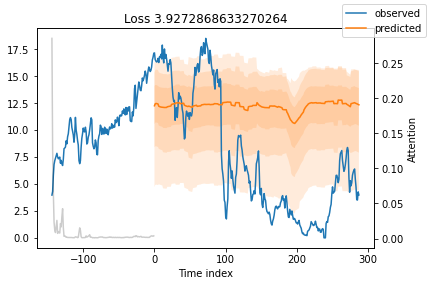

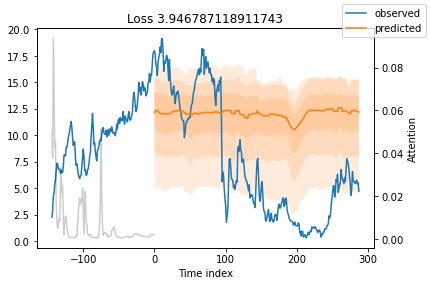

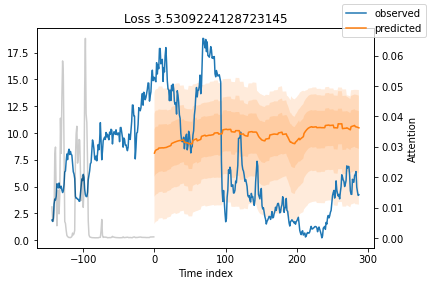

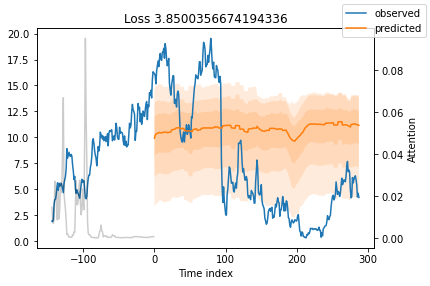

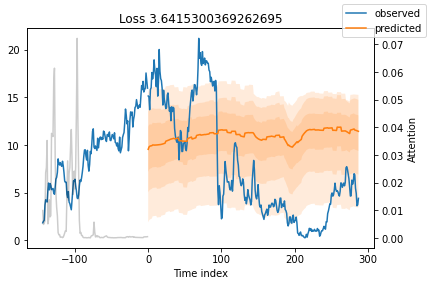

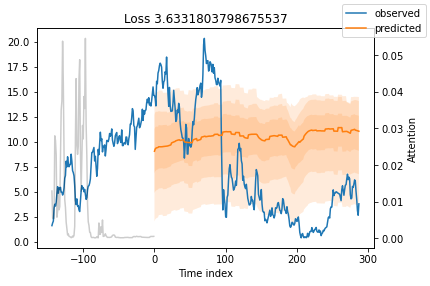

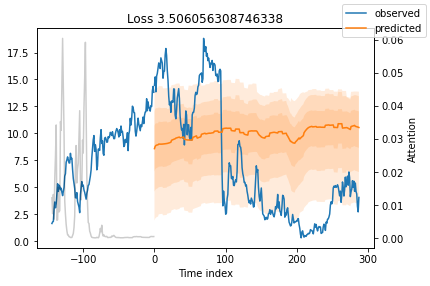

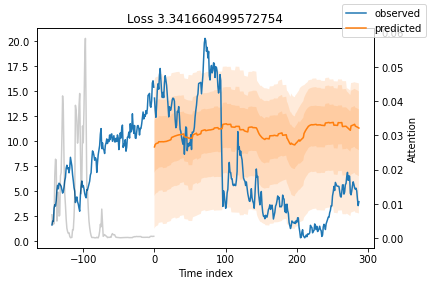

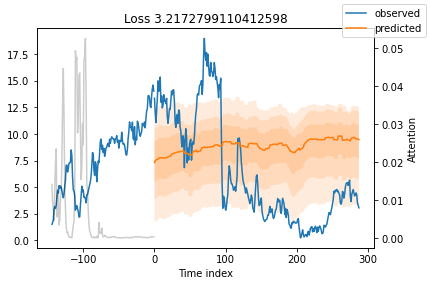

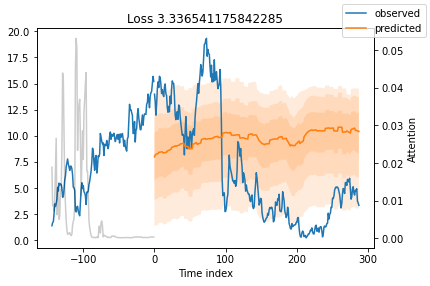

In [370]:
for idx in range(10):  # plot 10 examples
    #10개 그룹만 보기
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


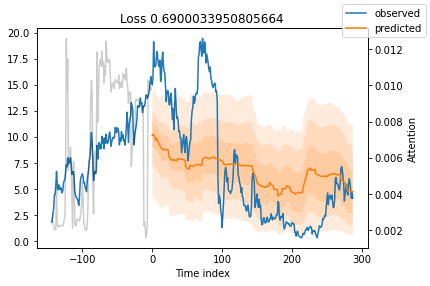

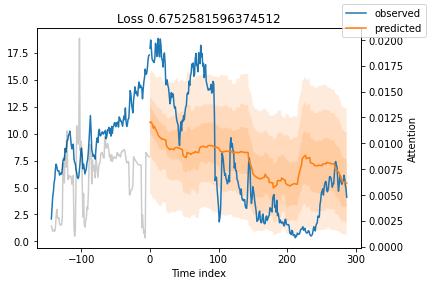

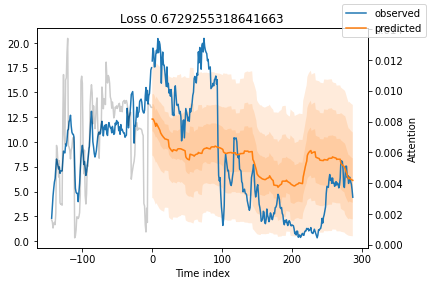

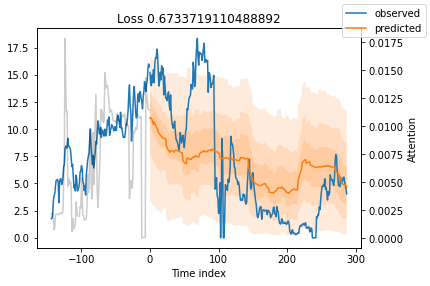

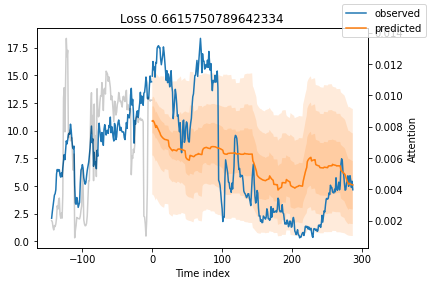

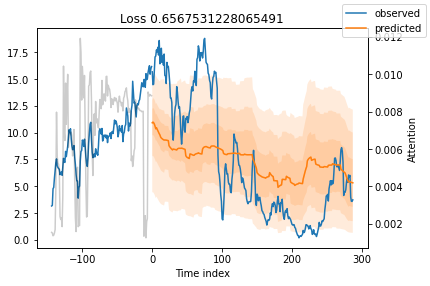

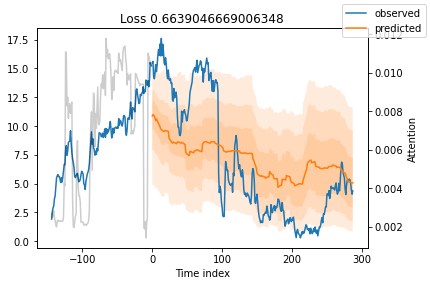

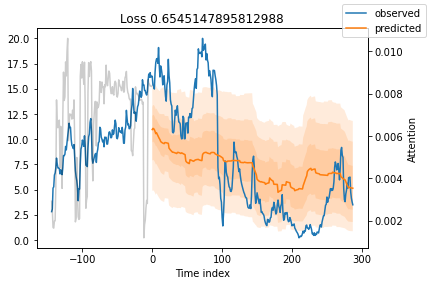

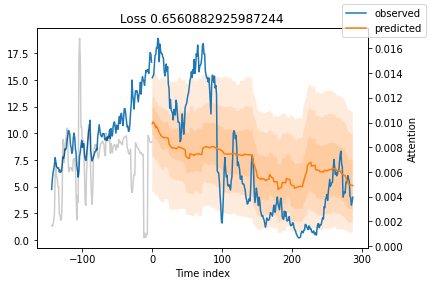

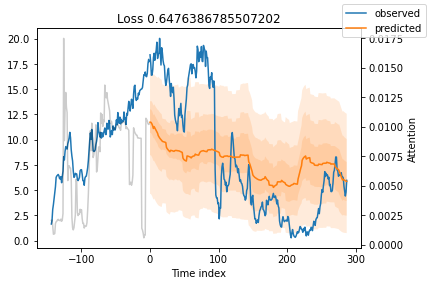

In [362]:
# worst 결과

# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

# 결과 해석

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>,
 'encoder_variables': <Figure size 504x414 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

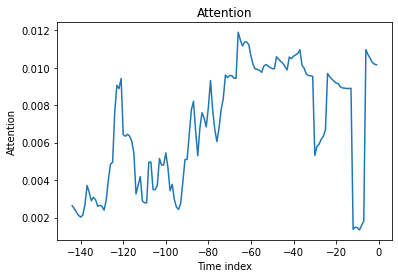

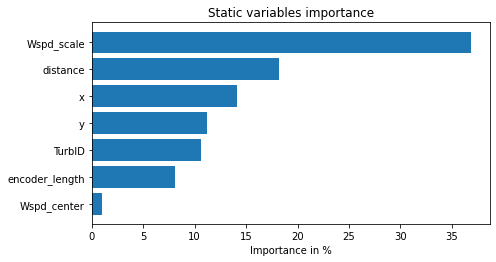

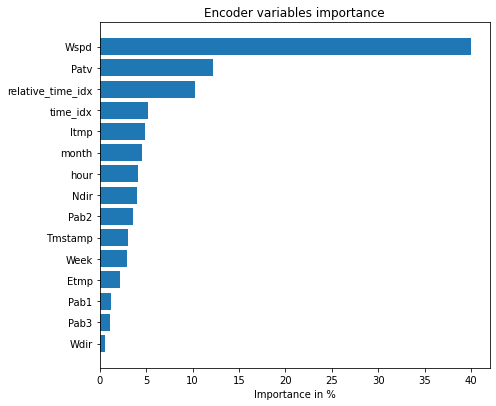

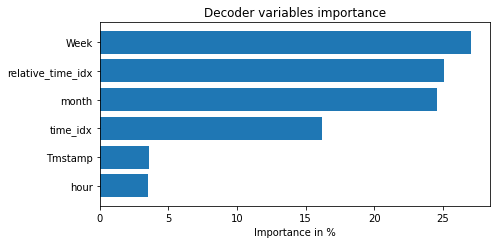

In [363]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [179]:
last_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,x,y,time_idx,month
28799,1,2021-07-19 23:50:00,23,3.97,0.92,10.96,28.46,191.23,0.99,0.99,0.99,-0.27,218.70,3349.8515,5939.23193,28799,7
57599,2,2021-07-19 23:50:00,23,3.76,0.74,3.16,18.01,224.55,0.49,0.49,0.49,-93.24,195.85,3351.0017,6416.64673,28799,7
86399,3,2021-07-19 23:50:00,23,4.02,-7.78,8.04,21.63,443.92,0.01,0.01,0.01,-81.46,218.39,3314.7797,6892.18395,28799,7
115199,4,2021-07-19 23:50:00,23,3.30,6.11,13.55,12.95,196.01,0.01,0.01,0.01,-73.28,154.20,3352.0940,7366.14203,28799,7
143999,5,2021-07-19 23:50:00,23,3.50,3.76,6.82,13.57,188.91,0.01,0.01,0.01,-78.78,163.87,3355.3420,7841.20175,28799,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3743999,130,2021-07-19 23:50:00,23,3.88,-2.32,8.80,14.96,315.58,0.01,0.01,0.01,-81.62,169.86,12.6509,4814.60040,28799,7
3772799,131,2021-07-19 23:50:00,23,4.23,1.58,8.47,19.61,495.44,0.01,0.01,0.01,-96.78,236.35,23.3458,5284.65439,28799,7
3801599,132,2021-07-19 23:50:00,23,4.96,-1.99,8.40,27.74,219.91,0.01,0.00,0.01,-110.77,230.80,62.6774,5749.90633,28799,7
3830399,133,2021-07-19 23:50:00,23,3.69,-6.95,10.19,12.94,177.97,0.01,0.01,0.01,-108.56,232.06,78.4309,6231.32903,28799,7


In [186]:
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
# 이 부분을 고쳐야 예측이 된다.

# time varying known은 다 적어줘야한다.
decoder_data1 = pd.concat(
    [last_data.assign(Day=lambda x: x.Day + pd.offsets.Minute(i*10)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()



hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]
data["Tmstamp"] = data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

In [187]:
decoder_data1

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,x,y,time_idx,month
0,1,2021-07-20 00:00:00,23,3.97,0.92,10.96,28.46,191.23,0.99,0.99,0.99,-0.27,218.70,3349.8515,5939.23193,28799,7
1,2,2021-07-20 00:00:00,23,3.76,0.74,3.16,18.01,224.55,0.49,0.49,0.49,-93.24,195.85,3351.0017,6416.64673,28799,7
2,3,2021-07-20 00:00:00,23,4.02,-7.78,8.04,21.63,443.92,0.01,0.01,0.01,-81.46,218.39,3314.7797,6892.18395,28799,7
3,4,2021-07-20 00:00:00,23,3.30,6.11,13.55,12.95,196.01,0.01,0.01,0.01,-73.28,154.20,3352.0940,7366.14203,28799,7
4,5,2021-07-20 00:00:00,23,3.50,3.76,6.82,13.57,188.91,0.01,0.01,0.01,-78.78,163.87,3355.3420,7841.20175,28799,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,130,2021-07-21 23:50:00,23,3.88,-2.32,8.80,14.96,315.58,0.01,0.01,0.01,-81.62,169.86,12.6509,4814.60040,28799,7
38588,131,2021-07-21 23:50:00,23,4.23,1.58,8.47,19.61,495.44,0.01,0.01,0.01,-96.78,236.35,23.3458,5284.65439,28799,7
38589,132,2021-07-21 23:50:00,23,4.96,-1.99,8.40,27.74,219.91,0.01,0.00,0.01,-110.77,230.80,62.6774,5749.90633,28799,7
38590,133,2021-07-21 23:50:00,23,3.69,-6.95,10.19,12.94,177.97,0.01,0.01,0.01,-108.56,232.06,78.4309,6231.32903,28799,7


In [182]:
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]
encoder_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,x,y,time_idx,month
28656,1,2021-07-19 00:00:00,0,7.12,0.82,8.89,26.50,201.67,1.00,1.00,1.00,-0.23,757.75,3349.8515,5939.23193,28656,7
28657,1,2021-07-19 00:10:00,0,7.45,4.21,8.67,26.44,201.67,1.00,1.00,1.00,-0.24,797.27,3349.8515,5939.23193,28657,7
28658,1,2021-07-19 00:20:00,0,8.05,4.93,8.48,26.32,203.37,1.00,1.00,1.00,-0.25,940.76,3349.8515,5939.23193,28658,7
28659,1,2021-07-19 00:30:00,0,6.50,3.00,8.28,26.28,211.53,1.00,1.00,1.00,-0.27,640.16,3349.8515,5939.23193,28659,7
28660,1,2021-07-19 00:40:00,0,4.16,-2.22,8.04,25.88,216.96,0.99,0.99,0.99,-0.26,256.80,3349.8515,5939.23193,28660,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,2021-07-19 23:10:00,23,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,11.3385,6713.46517,28795,7
3859196,134,2021-07-19 23:20:00,23,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,11.3385,6713.46517,28796,7
3859197,134,2021-07-19 23:30:00,23,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,11.3385,6713.46517,28797,7
3859198,134,2021-07-19 23:40:00,23,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,11.3385,6713.46517,28798,7


In [45]:
#predict on new data

# select last 24 months from data (max_encoder_length is 24)
#나는 여기서 144*5 time stamp를 가져온다.
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
# 이 부분을 고쳐야 예측이 된다.

#Day 등 피처를 수정하는 과정.
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)
#앞으로 6달 예측

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
# add time index
data['time_idx'] = ( ( (data["Day"].dt.dayofyear-1)*24*60 + data["Day"].dt.hour*60 + data["Day"].dt.minute ) /10 ).astype(int)
# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [47]:
encoder_data
#350 * 24 

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
1395,Agency_04,SKU_03,329.9400,2016-01-01,517389425,787479774,20.331481,1555.174877,1364.590954,190.583923,...,-,-,-,12.254823,215,36,1,5.798911,1305.280042,79.215120
1396,Agency_05,SKU_04,2983.4910,2016-01-01,517389425,787479774,24.405797,2135.424114,1801.804597,333.619517,...,-,-,-,15.623103,20,36,1,8.000849,942.376267,1410.060200
1394,Agency_03,SKU_05,544.0446,2016-01-01,517389425,787479774,20.331481,1627.401548,1347.982304,279.419244,...,-,-,-,17.169656,202,36,1,6.299031,1091.665142,1580.954850
1397,Agency_42,SKU_05,371.5146,2016-01-01,517389425,787479774,22.841758,1629.296555,1228.912937,400.383618,...,-,-,-,24.574017,348,36,1,5.917588,1091.665142,316.032840
1221,Agency_46,SKU_17,0.0000,2016-01-01,517389425,787479774,23.100990,0.000000,0.000000,0.000000,...,-,-,-,0.000000,321,36,1,-18.420681,0.000000,2971.672950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765,Agency_08,SKU_03,9.8136,2017-12-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,-,-,-,14.717926,336,59,12,2.283769,2304.827516,76.037400
6764,Agency_60,SKU_05,2235.3495,2017-12-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,-,-,-,19.503372,188,59,12,7.712153,1530.930920,3311.367493
6763,Agency_19,SKU_05,87.5430,2017-12-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,-,-,-,18.655677,162,59,12,4.472130,1530.930920,56.557950
6771,Agency_60,SKU_03,325.8792,2017-12-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,-,-,-,15.257220,187,59,12,5.786527,2304.827516,3311.367493


In [46]:
decoder_data

#350* 6 step

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_52,SKU_02,1455.40800,2018-01-01,618073219,919709619,30.759805,1709.140347,1403.137086,306.003261,...,-,-,-,17.903928,47,60,1,7.283042,2267.730115,590.241720
1,Agency_32,SKU_05,3606.51600,2018-01-01,618073219,919709619,22.717406,1924.429706,1559.952757,364.476949,...,-,-,-,18.939478,147,60,1,8.190497,1530.930920,1863.056125
2,Agency_09,SKU_21,0.92655,2018-01-01,618073219,919709619,31.129991,2476.908694,2233.819815,243.088879,...,-,-,-,9.814204,53,60,1,-0.076287,0.354645,2434.174114
3,Agency_08,SKU_04,186.77970,2018-01-01,618073219,919709619,25.373665,2486.862499,1934.749052,552.113447,...,-,-,-,22.201205,335,60,1,5.229930,1408.486009,76.037400
4,Agency_52,SKU_05,963.10050,2018-01-01,618073219,919709619,30.759805,1890.908050,1632.868569,258.039481,...,-,-,-,13.646326,46,60,1,6.870158,1530.930920,590.241720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,Agency_08,SKU_03,9.81360,2018-06-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,-,-,-,14.717926,336,65,6,2.283769,2304.827516,76.037400
2096,Agency_60,SKU_05,2235.34950,2018-06-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,-,-,-,19.503372,188,65,6,7.712153,1530.930920,3311.367493
2097,Agency_19,SKU_05,87.54300,2018-06-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,-,-,-,18.655677,162,65,6,4.472130,1530.930920,56.557950
2098,Agency_60,SKU_03,325.87920,2018-06-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,-,-,-,15.257220,187,65,6,5.786527,2304.827516,3311.367493
